In [2]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams["figure.figsize"] = (3,3)
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

Suivi de position en mer
======================

Le but de ce projet est de simuler et prévoir en temps réel la position de navires en mer à partir de données GPS. En effet, la plupart de la flotte mondiale est maintenant équippée d'un AIS (Automatic Identification System) 

https://shipping.nato.int/nsc/operations/news/2021/ais-automatic-identification-system-overview

qui communique régulièrement aux côtes et aux satellites la position de chaque bateau. Les données sont en fait disponibles publiquement et en temps réel sur 

https://www.marinetraffic.com/en/ais/home/centerx:-4.5/centery:50.8/zoom:6

Ces communications permettent le suivi des positions et l'identification des navires à la fois aux côtes et à chacun des navires pour éviter les collisions.

Considérons un bateau modélisé par sa position 2D $(x_1,x_2)\in \mathbb{R}^2$ dans le plan de la mer (on néglige la houle), et son orientation $x_3\in \mathbb{R}$
\begin{align*}
\dot{x}_1 &= v(t) \cos(x_3) \\
\dot{x}_2 &= v(t) \sin(x_3) \\
\dot{x}_3 &= w(t)
\end{align*}
où $v$ et $w$ sont les vitesses linéaires et de rotation respectivement. On souhaite estimer la position en temps réel de ce bateau à partir de mesures GPS bruitées sans connaître les signaux $v$ et $w$. Pour cela, nous allons d'abord étudier la simulation numérique des trajectoires de ce bateau, puis apprendre à implémenter un *filtre de Kalman* permettant le filtrage des données GPS grâce à la connaissance d'un modèle approximé. 

Notons que dans ce projet, nous supposons la position GPS disponible continûment (à chaque instant) alors qu'elle est en fait échantillonnée en pratique, et il faut alors utiliser des méthodes discrètes mêlant la prédiction par le modèle et le recalage par les mesures (filtre de Kalman discret, filtre particulaire). Ce sont des algorithmes probabilistes que vous verrez dans le projet numérique de probabilités.


In [3]:
def f(t,x):
    v = 10.0 
    w = 10.0 
    return np.array([v*np.cos(x[2]),v*np.sin(x[2]),w])

Euler explicite
================

**Question 1** Compléter les fonctions ``solve_euler_explicit`` et ``predict_euler_explicit`` ci-dessous prenant en entrée une fonction $f: \mathbb{R}\times\mathbb{R}^n \to \mathbb{R}^n$ quelconque, une condition initiale $x_0$, un pas de temps $dt$, les temps initiaux et finaux, et renvoyant 

- le vecteur des temps $t^j$ et de la solution $x^j$ du schéma d'Euler explicite appliqué à $\dot{x}=f(t,x)$,

- la valeur finale au temps $t_f$ de la solution du schéma d'Euler explicite appliqué à $\dot{x}=f(t,x)$,

respectivement.

In [4]:
def solve_euler_explicit(f, x0, dt, t0, tf):
    ts, xs = [t0], [x0]
    while ts[-1] < tf:
        t, x = ts[-1], xs[-1]
        t_next, x_next = t + dt, x + dt * f(t,x)
        ts.append(t_next); xs.append(x_next)
    return (np.array(ts), np.array(xs).T)

def predict_euler_explicit(f, x0, dt, t0, tf):
    t, x = t0, x0
    while t < tf:
        t_next, x_next = t + dt, x + dt * f(t,x)
        t, x = t_next, x_next
    return x

**Question 2** Utiliser ``solve_euler_explicit`` pour simuler des trajectoires simples et connues de bateau (ligne droite et cercle notamment). Etudier l'erreur numérique du schéma
- lorsque $\Delta t$ tend vers 0 pour un horizon de temps $t_f$ fixé ; 
- à $\Delta t$ fixé, lorsque $t_f$ augmente : arrivez-vous à simuler une trajectoire circulaire en temps long?

Expliquer comment trouver numériquement (sans le faire) l'ordre de convergence du schéma.

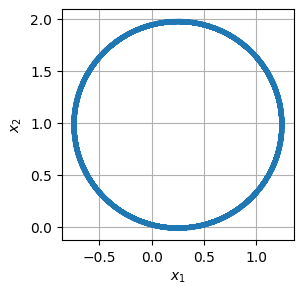

Valeur finale de l'état :  [ -0.72331613   1.25065264 300.        ]


In [5]:
x0 = np.array([0.0,0.0,0.0])
dt = 0.05
t0, tf = 0.0, 30.0
t_explicit, x_explicit = solve_euler_explicit(f, x0, dt, t0, tf)

plt.figure()
plt.plot(x_explicit[0],x_explicit[1])
plt.grid(True)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

print("Valeur finale de l'état :  %s" % predict_euler_explicit(f, x0, dt, t0, tf))



Avec ce choix de $v$ et $w$, le navire est censé tourner indéfiniment sur un cercle. Lorsqu'on fixe $t_f$ à 1, et on décroit le pas de temps, l'erreur numérique décroit, on voit progressivement un cercle se former (sorte de polygone pour un pas de 0.1, et un cercle pour 0.01). Lorsqu'on fixe le pas à 0.05 et on augmente le temps final par contre, l'erreur s'accumule, le cercle a tendance à s'épaissir car le bateau ne revient pas en son point initial. Ceci dit sur cet exemple particulier, le motif semble stable même pour des temps très longs (alors que sur d'autres exemples, on pourrait diverger)
Si on voulait trouver l'ordre du schéma numérique, on simulerait une trajectoire connue (ligne droite, cercle) pendant un temps fixé pour des pas de temps de plus en plus petit, et on comparerait la trajectoire obtenue à la théorique pour chacun des pas de temps, et on tracerait cette erreur numérique en fonction du pas de temps. En échelle log, on majorerait ces points par une droite dont la pente donne l'ordre du schéma.

Modèle d'estimation
====================

Notre fonction de prédiction demande un pas de temps suffisamment petit et surtout nécessite de connaitre les vitesses $v$ et $w$ du bateau. On souhaite être capable de suivre la trajectoire du bateau sans connaitre ces quantités, en exploitant des mesures de position intermittentes obtenues par GPS. On suppose pour cela que les vitesses $v$ et $w$ varient lentement et on adopte donc le modèle étendu (approximé)
\begin{align}
\dot{x}_1 &= x_4 \cos(x_3) \\
\dot{x}_2 &= x_4 \sin(x_3) \\
\dot{x}_3 &= x_5 \\
\dot{x}_4 &= 0 \\
\dot{x}_5 &= 0 
\end{align}

In [6]:
def f_ext(t,x):
    return np.array([x[3]*np.cos(x[2]),x[3]*np.sin(x[2]),x[4],0,0])

Text(0, 0.5, '$x_2$')

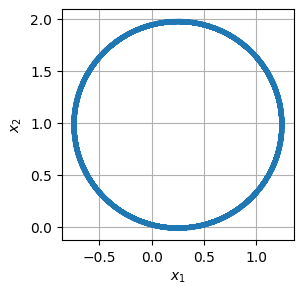

In [7]:
x0 = np.array([0.0,0.0,0.0,10.0,10.0])  
dt = 0.05
t0, tf = 0.0, 30.0
t_explicit, x_explicit = solve_euler_explicit(f_ext, x0, dt, t0, tf)

plt.figure()
plt.plot(x_explicit[0],x_explicit[1])
plt.grid(True)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

On suppose dans ce projet que l'on dispose d'une mesure GPS de position $y=(x_1,x_2)$ à chaque instant et que l'on souhaite estimer la position $(x_1,x_2)$, l'angle $x_3$ et les vitesses $(x_4,x_5)$ en temps réel. Estimer la position déjà connue par le GPS peut paraître inutile mais la mesure est souvent bruitée et l'information du modèle d'évolution peut permettre de réduire ou "filtrer" ce bruit.

**Question** Justifier que le système théorique donné par ``f_ext`` et $y$ est *observable*, c'est-à-dire que la connaissance de $t\mapsto y(t) = (x_1(t),x_2(t))$ détermine de manière unique tout l'état $(x_1,x_2,x_3,x_4,x_5)$. Est-ce une bonne idée de calculer analytiquement $x_3,x_4,x_5$ à partir de $y$ ?

**Réponse** En dérivant $y$, on trouve $(x_4 \cos x_3, x_4 \sin x_3)$ dont la norme donne $x_4$ et l'angle donne $x_3$ (à vitesse non nulle) Ensuite la dérivée de $x_3$ donne $x_5$. Ceci cest un raisonnement théorique qui dit que l'information est contenue dans le signal $y$. Cependant, le signal $y$ étant bruité, c'est une très mauvaise idée de le dériver numériquement. 



On souhaite donc écrire un algorithme, appelé *observateur* ou *filtre*, qui prenne en entrée $y(t)$ et qui construise une estimée $\hat{x}(t)$ de $x(t)$ telle que $\hat{x}$ converge vers $x$ asymptotiquement.

Pour cela, il faut prendre en compte que le modèle donné par ``f_ext`` et $y$ n'est pas exact car il y a 2 sources d'incertitudes : les erreurs de mesure du GPS, et les accélérations $\dot{v}$ et $\dot{w}$ qui ne sont pas nulles en réalité. Le système réel est donc plutôt
\begin{align*}
\dot{x}_1 &= x_4 \cos(x_3) \\
\dot{x}_2 &= x_4 \sin(x_3) \\
\dot{x}_3 &= x_5 \hspace{5em} , \hspace{5em} y_m = (x_1 ,x_2) + \delta_y(t) \\
\dot{x}_4 &= \delta_v(t) \\
\dot{x}_5 &= \delta_w(t)
\end{align*}
avec $\delta_v\in \mathbb{R}$, $\delta_w\in \mathbb{R}$, $\delta_y\in \mathbb{R}^2$, des entrées *faibles* mais inconnues. L'observateur doit donc être *robuste* aux erreurs de modèles et de mesure.

Etude théorique du filtre de Kalman étendu déterministe
==============

Considérons un système dynamique décrit par
$$
\dot{x} = f(t,x) + \delta_f(t) \quad , \quad y_m = h(t,x)+ \delta_h(t) 
$$
où $x\in \mathbb{R}^n$ est l'état du système, $y\in \mathbb{R}^p$ est la mesure connue, et $\delta_f,\delta_h$ sont des incertitudes inconnues que l'on suppose bornées. 

Etant donné la mesure $t\mapsto y_m(t)$, on s'intéresse alors à implémenter un *filtre de Kalman* donné par
\begin{align}
\dot{\hat{x}} & = f(t,\hat{x})+ P\frac{\partial h}{\partial x}(t,\hat{x})^\top R^{-1} (y_m(t)-h(t,\hat{x})) 
\\
\dot{P} & = \lambda P + \frac{\partial f}{\partial x}(t,\hat{x}) P + P\frac{\partial f}{\partial x}(t,\hat{x})^\top + Q - P \frac{\partial h}{\partial x}(t,\hat{x})^\top R^{-1} \frac{\partial h}{\partial x}(t,\hat{x}) P
\end{align}
où $\hat{x}\in \mathbb{R}^n$, $P\in \mathbb{R}^{n\times n}$ constitue l'état du filtre, et où les paramètres $\lambda\in \mathbb{R}$, $Q\in \mathbb{R}^{n\times n}$, $R\in \mathbb{R}^{p\times p}$ sont à choisir tels que
- $\lambda \geq 0$ et $Q$ est symétrique, à valeurs propres positives (matrice positive),
- $R$ est symétrique, à valeurs propres strictement positives (matrice définie positive),
- $\lambda > 0$ ou bien $Q$ est à valeurs propres strictement positives.

Cet algorithme compare à chaque instant les mesures aux estimées et corrige ainsi ces estimées dynamiquement, en temps réel. En effet, $x(0)$ étant mal connue, le modèle étant imparfait, et les erreurs numériques s'accumulant, la simulation sans ces corrections serait impossible. On va donc montrer que modulo les erreurs de modèle et de mesure, c'est algorithme converge localement, c'est-à-dire, $\hat{x}$ tend vers $x$ si l'erreur initiale $\hat{x}(0)-x(0)$ est suffisamment faible.

Pour cela, on admet ici que si $P(0)$ est symétrique à valeurs propres strictement positives, alors $P(t)$ le reste pour tout $t\geq 0$. De plus, on admet que le long des trajectoires, il existe $\rho_1>0$ et $\rho_2>0$ tels que 
$$
\rho_1 I_n \leq P^{-1}(t) \leq \rho_2 I_n \quad \forall t\geq 0 \ ,
$$
où $I_n$ est la matrice identité de dimension $n$. En particulier, $P$ ne tend pas à devenir singulière, ni diverger. Cette dernière hypothèse est cruciale dans la théorie du filtre de Kalman et se justifie sous des hypothèses d'*observabilité* dans le cas des systèmes linéaires. Mais l'étude de cette hypothèse nous amènerait bien trop loin pour ce projet... (voir remarque ci-dessous)

En considérant le système complet d'état $(x,\hat{x},P)$ avec $P$ inversible, posons
$$
V(x,\hat{x},P) = (\hat{x}-x)^\top P^{-1} (\hat{x}-x) \ .
$$

**Question** On suppose que les dérivées partielles de $f$ et $h$ par rapport à $x$ au premier et second ordre sont globalement bornées. En déduire qu'étant donnés $Q,R,\lambda, \rho_1,\rho_2$, il existe $\kappa_f\geq 0$, $\kappa_h\geq 0$, $k>0$, et $\varepsilon >0$, $\delta\geq 0$, tels que pour tout $(t,x,\hat{x})\in \mathbb{R}^+ \times \mathbb{R}^n \times \mathbb{R}^n$,
\begin{align}
\left\|f(t,x)-f(t,\hat{x})-\frac{\partial f}{\partial x}(t,\hat{x}) (x-\hat{x})\right\| &\leq \kappa_f \|x-\hat{x}\|^2\\
\left\|h(t,x)-h(t,\hat{x})-\frac{\partial h}{\partial x}(t,\hat{x}) (x-\hat{x})\right\| &\leq \kappa_h \|x-\hat{x}\|^2
\end{align}
et 
$$
\frac{d}{dt}V(x(t),\hat{x}(t),P(t)) \leq - k V(x(t),\hat{x}(t),P(t)) + \delta
$$
le long des trajectoires vérifiant $\|\hat{x}(t)-x(t) \|<\varepsilon$. En déduire qu'il existe $k'>0,\rho'>0,\delta'\geq 0$ tels que si $\|\hat{x}(0)-x(0)\|$, $\delta_f$ et $\delta_h$ sont suffisamment faibles, 
$$
\|\hat{x}(t)-x(t) \| \leq \rho' e^{-k' t} \|\hat{x}(0)-x(0) \|  + \delta' \qquad \forall t\geq 0,
$$
avec $\delta'=0$ en l'absence d'incertitudes, i.e., si $\delta_f=0$ et $\delta_h=0$.

*Indice* : Montrer que $\frac{d}{dt}P^{-1}(t)=-P^{-1}(t) \left(\frac{d}{dt}P(t) \right) P^{-1}(t) $. On rappelle aussi que par Cauchy-Schwarz, pour tout $(x,y)\in \mathbb{R}^n\times \mathbb{R}^n$ et pour toute matrice symétrique $P$ à valeurs propres strictement positives (matrice définie positive), on a $x^\top P y \leq \sqrt{x^\top P x} \sqrt{y^\top P y}$. On rappelle aussi l'inégalité de Young :  pour tout $(a,b) \in \mathbb{R}\times \mathbb{R}$ et pour tout $\gamma>0$, $2 ab \leq \gamma a^2 +\frac{1}{\gamma} b^2$.

**Réponse** Les inégalités (1) et (2) sont obtenues par la formule des accroissements finis au second ordre. 

Ensuite, en écrivant que $P(t)P^{-1}(t)=I_n$ pour tout $t$, et en dérivant par rapport au temps, on a 
$$
\left[\frac{d}{dt} P(t) \right] P^{-1}(t) + P(t)\left[\frac{d}{dt} P^{-1}(t) \right] = 0
$$
d'où
$$
\frac{d}{dt}P^{-1}(t)=-P^{-1}(t) \left(\frac{d}{dt}P(t) \right) P^{-1}(t) 
$$
Par ailleurs on a 
$$
\frac{d}{dt} V = \left[\frac{d}{dt}(\hat{x}-x)\right]^\top P^{-1} (\hat{x}-x) + (\hat{x}-x)^\top \left[\frac{d}{dt} P^{-1} \right] (\hat{x}-x) + (\hat{x}-x)^\top P^{-1} \left[\frac{d}{dt}(\hat{x}-x)\right]
$$
et
$$
\frac{d}{dt}(\hat{x}-x) = f(t,\hat{x}) - f(t,x) -\delta_f+ P\frac{\partial h}{\partial x}(t,\hat{x})^\top R^{-1} (h(t,x)+\delta_h-h(t,\hat{x}))
$$
En développant $f(t,\hat{x}) - f(t,x)=\frac{\partial f}{\partial x}(t,\hat{x}) (\hat{x}-x) + \Delta f$ et $h(t,\hat{x})-h(t,x)=\frac{\partial h}{\partial x}(t,\hat{x}) (\hat{x}-x) + \Delta h$, on obtient
\begin{align*}
\frac{d}{dt} V &= \left( \frac{\partial f}{\partial x}(t,\hat{x}) (\hat{x}-x) + \Delta f \right)^\top P^{-1} (\hat{x}-x)  +  (\hat{x}-x)^\top P^{-1} \left( \frac{\partial f}{\partial x}(t,\hat{x}) (\hat{x}-x) + \Delta f \right)\\& -2 (\hat{x}-x)^\top P^{-1} \delta_f-2(\hat{x}-x)^\top\frac{\partial h}{\partial x}(t,\hat{x})^\top R^{-1}\left( \frac{\partial h}{\partial x}(t,\hat{x})(\hat{x}-x) +\Delta h\right)\\&  + 2(\hat{x}-x)^\top\frac{\partial h}{\partial x}(t,\hat{x})^\top R^{-1}\delta_h + (\hat{x}-x)^\top \left(\frac{d}{dt} P^{-1}\right) (\hat{x}-x)
\end{align*}
avec $\|\Delta f\|\leq\kappa_f \|x-\hat{x}\|^2$ and $\|\Delta h\|\leq\kappa_h \|x-\hat{x}\|^2$.
Par ailleurs, on a 
$$
\frac{d}{dt}P^{-1} = -\lambda P^{-1} - P^{-1}\frac{\partial f}{\partial x}(t,\hat{x}) - \frac{\partial f}{\partial x}(t,\hat{x})^\top P^{-1} - P^{-1}QP^{-1} + \frac{\partial h}{\partial x}(t,\hat{x})^\top R^{-1} \frac{\partial h}{\partial x}(t,\hat{x})
$$
Et donc
\begin{align*}
\frac{d}{dt} V &= - \lambda V - (\hat{x}-x)^\top P^{-1}QP^{-1}(\hat{x}-x) -(\hat{x}-x)^\top\frac{\partial h}{\partial x}(t,\hat{x})^\top R^{-1} \frac{\partial h}{\partial x}(t,\hat{x})(\hat{x}-x) \\&+ 2 (\hat{x}-x)^\top P^{-1} \Delta f -2(\hat{x}-x)^\top\frac{\partial h}{\partial x}(t,\hat{x})^\top R^{-1}\Delta h\\& -2 (\hat{x}-x)^\top P^{-1} \delta_f + 2(\hat{x}-x)^\top\frac{\partial h}{\partial x}(t,\hat{x})^\top R^{-1}\delta_h
\end{align*}
Par définition de $\rho_1,\rho_2$, pour tout $t$, $x,\hat{x}$,
$$
\rho_1 \|\hat{x}-x\|^2 \leq V(t,x,\hat{x}) \leq \rho_2 \|\hat{x}-x\|^2  \ .
$$
En utilisant Cauchy Schwarz, en notant $c_r$ une borne de $R^{-1}$, et $c_f$ et $c_h$ les bornes des normes des jacobiennes de $f$ et $h$ respectivement (car les dérivées partielles sont supposées globalement bornées),
$$
(\hat{x}-x)^\top P^{-1} \Delta f\leq  \sqrt{V} \sqrt{\Delta f^\top P^{-1} \Delta f} \leq \sqrt{\rho_2} \sqrt{V} \|\Delta f\|\leq \kappa_f \sqrt{\rho_2} \sqrt{V} \|\hat{x}-x\|^2 \leq \kappa_f \sqrt{\frac{\rho_2}{\rho_1}} \|\hat{x}-x\| V
$$
$$
(\hat{x}-x)^\top\frac{\partial h}{\partial x}(t,\hat{x})^\top R^{-1}\Delta h \leq c_h c_r \|\hat{x}-x\| \|\Delta h\| \leq \kappa_h c_h c_r  \|\hat{x}-x\|^3 \leq \kappa_h c_h c_r \frac{1}{\rho_1}\|\hat{x}-x\| V
$$
$$
(\hat{x}-x)^\top P^{-1} \delta_f \leq \sqrt{V} \sqrt{\delta_f^\top P^{-1} \delta_f} \leq \sqrt{\rho_2}\sqrt{V} \|\delta_f\|
$$
$$
(\hat{x}-x)^\top\frac{\partial h}{\partial x}(t,\hat{x})^\top R^{-1}\delta_h \leq c_h c_r \|\hat{x}-x\| \|\delta_h\| \leq \frac{c_h c_r}{\sqrt{\rho_1}} \sqrt{V} \|\delta_h\|
$$
En notant $\rho_q\geq 0$ la plus petite valeur propre de $Q$,
$$
(\hat{x}-x)^\top P^{-1}QP^{-1}(\hat{x}-x) \geq \rho_q \rho_1^2 \|\hat{x}-x\|^2 \geq \rho_q \rho_1 V
$$
On a donc 
$$
- \lambda V - (\hat{x}-x)^\top P^{-1}QP^{-1}(\hat{x}-x)\leq - (\lambda + \rho_q \rho_1) V
$$
et $\lambda_v:=\lambda + \rho_q \rho_1>0$ par hypothèse.
Il s'ensuit que
\begin{align}
\frac{d}{dt} V  &\leq - \left(\lambda_v - 2 \left(\kappa_f \sqrt{\frac{\rho_2}{\rho_1}}+\kappa_h c_h c_r \frac{1}{\rho_1} \right) \|\hat{x}-x\| \right) V  + 2\left(\sqrt{\rho_2} \|\delta_f\|+ \frac{c_h c_r}{\sqrt{\rho_1}} \|\delta_h\| \right) \sqrt{V} \\
&\leq - \frac{\lambda_v}{2} V + 2\left(\sqrt{\rho_2} \|\delta_f\|+ \frac{c_h c_r}{\sqrt{\rho_1}} \|\delta_h\| \right) \sqrt{V}
\end{align}
si $ \|\hat{x}-x\|<\frac{1}{4}\frac{\lambda_v}{\kappa_f \sqrt{\frac{\rho_2}{\rho_1}}+\kappa_h c_h c_r \frac{1}{\rho_1}}$ et par inégalité de Young,
$$
\frac{d}{dt} V  \leq - \frac{\lambda_v}{4} V + \frac{4}{\lambda_v} \left(\sqrt{\rho_2} \bar \delta_f+ \frac{c_h c_r}{\sqrt{\rho_1}} \bar \delta_h \right)^2 
$$
où $ \bar \delta_f$ et $ \bar \delta_h$ sont les bornes des bruits de dynamique et mesure respectivement.
En multipliant par $e^{\frac{\lambda_v}{4}t}$ de chaque côté et en intégrant de 0 à $t$, on trouve
$$
V(t) \leq e^{\frac{-\lambda_v}{4}t}V(0) + \left(\frac{4}{\lambda_v}\right)^2 \left(\sqrt{\rho_2} \bar \delta_f+ \frac{c_h c_r}{\sqrt{\rho_1}} \bar \delta_h \right)^2 
$$
et donc en passant à la racine
$$
\|\hat{x}(t)-x(t)\|\leq \sqrt{\frac{\rho_2}{\rho_1}}e^{\frac{-\lambda_v}{8}t}\|\hat{x}(0)-x(0)\| + \frac{4}{\lambda_v}\left(\sqrt{\frac{\rho_2}{\rho_1}} \bar \delta_f+ \frac{c_h c_r}{\rho_1} \bar \delta_h \right)
$$

**Remarque** Notons ici que l'analyse théorique du filtre de Kalman admet souvent un cercle vicieux: la dynamique de $P$, et donc les paramètres $\rho_1$ et $\rho_2$, dépendent de $\hat{x}$, et on a besoin de $\rho_1$ et $\rho_2$ pour montrer la convergence de $\hat{x}$ vers $x$. Ce problème peut être résolu dans certains cas pour des structures particulières ou sous des hypothèses très fortes d'observabilité uniforme. En fait, le filtre de Kalman a initialement été développé pour les systèmes linéaires, où la dynamique de $P$ est indépendante de $\hat{x}$ et où les paramètres $\rho_1$ et $\rho_2$ sont donc des propriétés *intrinsèques* du système (liés à son observabilité) et indépendants de $\hat{x}$. La convergence de l'estimation découle alors sans cercle vicieux, et est même *globale*, c'est-à-dire sans restriction sur l'erreur initiale $\|\hat{x}(0)-x(0) \|$ (ni sur les incertitudes). Vous pouvez le vérifier en prenant $\kappa_f=0$ et $\kappa_h=0$. Mais vu sa grande practicité, ce filtre a ensuite été *étendu* aux systèmes nonlinéaires comme décrit ci-dessus (d'où son nom, *extended Kalman filter*, "EKF"), et est l'un des filtres les plus implémentés dans l'industrie (dans sa version discrète). Il est utile de connaître cet algorithme tout en ayant conscience de ses limites... Des variantes, telles que le *unscented Kalman filter* dans sa version probabiliste, permettent parfois d'obtenir de meilleurs résultats. Pour des systèmes très non linéaires, il vaut mieux utiliser des observateurs adaptés plus complexes.

Application au suivi du bateau
================

On commence par simuler précisément une trajectoire continue quelconque de bateau, que l'on considèrera exacte. Bien sûr, en pratique cette solution exacte est inconnue, seule la mesure l'est, elle sera utilisée ici seulement pour comparer la solution estimée à la vraie, et évaluer ses performances.

In [8]:
def f_traj(t,x):
    v = 2.0 
    w = np.sin(t)
    return np.array([v*np.cos(x[2]),v*np.sin(x[2]),w])

[ 7.37195036 13.20715265]


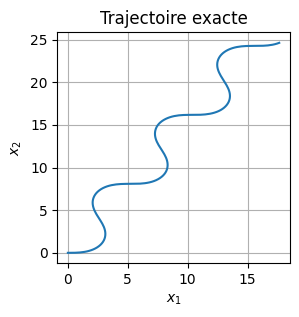

In [9]:
# simulation d'une trajectoire continue à haute précision, que l'on considère exacte. 
# L'option ``dense_output`` de ``solve_ivp`` permet d'obtenir en sortie une fonction ``sol_traj.sol`` qui donne la solution 
# à n'importe quel temps (voir doc) Ceci est très utile lorsque vous ne savez pas d'avance à quel instant vous en aurez besoin
# (comme ici la mesure, voir fonction ``y_traj`` ci-dessous)
x0 = np.array([0.0,0.0,0.0])
t0, tf = 0.0, 20.0
sol_traj = solve_ivp(fun = f_traj, t_span = [t0, tf], y0 = x0, dense_output=True, t_eval = np.arange(t0,tf,0.1), rtol=1e-4)

plt.figure()
plt.plot(sol_traj.y[0],sol_traj.y[1])
plt.grid(True)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Trajectoire exacte')

def y_traj(t):
    # on sélectionne les deux premières composantes de la solution "exacte" au temps t : mesure de position exacte
    return sol_traj.sol(t)[:2] 

print(y_traj(10.0))

Puis on définit les paramètres et fonctions nécessaires à la simulation du filtre.

**Question** Compléter ci-dessous les fonctions ``jac_f_ext`` et ``jac_h_ext`` donnant les matrices jacobiennes des fonctions de dynamique et mesure théoriques $f_{ext}:\mathbb{R}^5\to \mathbb{R}^5$ and $h_{ext}:\mathbb{R}^5\to \mathbb{R}^2$ données par
$$
f_{ext}(x) = (x_4 \cos(x_3),x_4 \sin(x_3),x_5 ,0,0) \quad , \quad h_{ext} = (x_1,x_2)
$$
Vu que les incertitudes $\delta_v,\delta_w,\delta_y$ sont inconnues, ce sont ces fonctions qui seront utilisées dans le filtre.

In [10]:
# scénario de mesure
std_y = 1.0  # écart-type du bruit de mesure

# paramètres du filtre de Kalman
R = np.eye(2)
Rinv = np.linalg.inv(R)
Q = np.eye(5)
#Q = np.diag([0.0,0.0,0.0,5.0,5.0])
lbda = 1
xhat0 = np.array([5.0,-5.0,0.0,1.0,0.0])
P0 = np.eye(5)
xhatP0 = np.hstack([xhat0,P0[0,0],P0[0,1],P0[0,2],P0[0,3],P0[0,4],P0[1,1],P0[1,2],P0[1,3],P0[1,4],P0[2,2],P0[2,3],P0[2,4],P0[3,3],P0[3,4],P0[4,4]])

def jac_f_ext(t,x):
    # jacobian matrix of the dynamics f_ext
    return np.array([[0,0,-x[3]*np.sin(x[2]),np.cos(x[2]),0],
                     [0,0,x[3]*np.cos(x[2]),np.sin(x[2]),0],
                     [0,0,0,0,1],
                     [0,0,0,0,0],
                     [0,0,0,0,0]])

print(jac_f_ext(0,xhat0))

def jac_h_ext(t,x):
    # jacobian matrix of the output map h_ext = (x1,x2)
    return np.array([[1,0,0,0,0],
                     [0,1,0,0,0]])

print(jac_h_ext(0,xhat0))

def f_EKF(t,xhatP):
    xhat = xhatP[:5]
    Ps = xhatP[5:]
    P = np.array([[Ps[0],Ps[1],Ps[2],Ps[3],Ps[4]],
                  [Ps[1],Ps[5],Ps[6],Ps[7],Ps[8]],
                  [Ps[2],Ps[6],Ps[9],Ps[10],Ps[11]],
                  [Ps[3],Ps[7],Ps[10],Ps[12],Ps[13]],
                  [Ps[4],Ps[8],Ps[11],Ps[13],Ps[14]]])
    jac_f = jac_f_ext(t,xhat)
    jac_h = jac_h_ext(t,xhat)
    y_mes = y_traj(t) + 1*np.random.normal(0.0,std_y)
    xhat_dot = f_ext(t,xhat) + P @ np.transpose(jac_h) @ Rinv @ (y_mes-xhat[:2])
    P_dot = lbda*P + jac_f @ P + P @ np.transpose(jac_f) + Q - P @ np.transpose(jac_h) @ Rinv @ jac_h @ P
    return np.hstack([xhat_dot,P_dot[0,0],P_dot[0,1],P_dot[0,2],P_dot[0,3],P_dot[0,4],P_dot[1,1],P_dot[1,2],P_dot[1,3],P_dot[1,4],P_dot[2,2],P_dot[2,3],P_dot[2,4],P_dot[3,3],P_dot[3,4],P_dot[4,4]])

print(f_EKF(0,xhatP0))



[[ 0.  0. -0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[1 0 0 0 0]
 [0 1 0 0 0]]
[-4.27938433  4.72061567  0.          0.          0.          1.
  0.          0.          1.          0.          1.          1.
  0.          0.          2.          0.          1.          2.
  0.          2.        ]


**Question** Justifier que la fonction ``f_EKF`` donne bien la dynamique du filtre de Kalman étendu.

**Question** Implémenter le filtre en appliquant votre fonction ``solve_euler_explicit`` à ``f_EKF``. Comparer l'estimation obtenue avec la trajectoire exacte pour différentes valeurs de paramètres $(R,Q,\lambda)$ et conditions initiales, d'abord en absence de bruit de mesure, puis en introduisant le bruit. Que se passe-t-il lorsque $R$ est pris petit/grand ? Justifier qu'on relie ce paramètre à la confiance que l'on a en la mesure. Lorsqu'on rajoute le bruit de mesure, expliquer pourquoi l'on dit souvent que le filtre fait un compromis entre bruit de modèle et bruit de mesure.

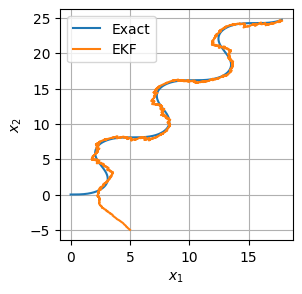

In [11]:
dt = 0.01
t_EKF, xhatP_EKF = solve_euler_explicit(f_EKF, xhatP0, dt, t0, tf)

plt.figure()
plt.plot(sol_traj.sol(t_EKF)[0],sol_traj.sol(t_EKF)[1], label = 'Exact')
plt.plot(xhatP_EKF[0],xhatP_EKF[1], label = 'EKF')
plt.grid(True)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

Lorsqu'on augmente $R$, le gain devant la correction par la mesure dans l'observateur diminue. Cela veut dire que l'estimée est essentiellement produite par la prédiction du modèle. Ici, vu que l'on a négligé les variations de vitesse, l'estimée va être plus lente et va avoir du mal à suivre des trajectoires rapides. A l'inverse, si l'on diminue $R$, le gain devant la mesure est grand donc le filtre est réactif mais par contre le bruit de mesure est amplifié car il est aussi multiplié par le gain. Il y a donc un compromis à faire entre bruit de mesure et incertitude de modèle. En fait, dans une interprétation stochastique, la matrice $R$ est la covariance du bruit de mesure et la matrice $Q$ est la covariance du bruit de modèle. Mais c'est le poid de l'un par rapport à l'autre qui est important (ou des composantes les unes par rapport aux autres) et qui détermine si l'on fait plus confiance en l'un ou l'autre.  

Le filtre de Kalman étendu continu et déterministe présenté ici a plusieurs défauts :
- la convergence n'est que locale (mais cela vient de la nonlinéarité et on n'y échappe pas, à moins de recourir à des algorithmes très différents et plus complexes),
- il nécessite d'avoir à disposition la mesure GPS en tout temps,
- il ne dit pas comment choisir les paramètres.

En pratique, on implémente plutôt la discrétisation du filtre de Kalman, qui permet de prédire par le modèle (Euler explicite) la position du bateau lorsqu'aucune mesure n'est disponible, puis de "recâler/corriger" l'estimée lorsque la mesure est disponible, en comparant la mesure à l'estimée comme ci-dessus. 

Par ailleurs, le filtre de Kalman admet, dans le contexte linéaire, une interprétation stochastique qui permet de le voir comme le filtre optimal qui minimise la variance de l'erreur d'estimation lorsque les incertitudes de mesures et de modèles sont interprétées comme des bruits blancs gaussiens. C'est en fait ainsi qu'il a été inventé. Les matrices $R$ et $Q$ sont alors directement reliés à la variance des incertitudes, ce qui en fait un filtre très intuitif à régler et ce qui justifie son succès dans l'industrie. Vous verrez donc la suite de ce projet en cours de Probabilités !